In [ ]:
del env

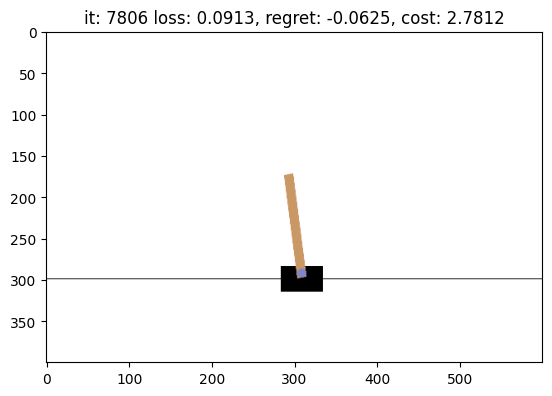

In [1]:
from typing import Optional, Tuple
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from multipath.nn.modules import Decoder
import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
import torch._dynamo

env = gym.make("CartPole-v1", render_mode="rgb_array", autoreset=True)
env.reset()
observation, info = env.reset(seed=42)



class WorldModel(nn.Module):

    def __init__(self, num_states: int, num_actions: int, num_layers: int, hidden_size: int = 64):
        super().__init__()
        self.action_embeds = nn.Embedding(num_actions, hidden_size, dtype=torch.bfloat16)
        self.state_ebmeds = nn.Linear(num_states, hidden_size)

        self.layers = nn.Sequential()
        for _ in range(num_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.InstanceNorm1d(hidden_size))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(hidden_size, num_states))
    
    def forward(self, s: Tensor, a: Tensor) -> Tensor:
        s = self.state_ebmeds(s)
        a = self.action_embeds(a)
        h = s + a
        h = F.dropout(h, p=0.1, training=True)
        h = self.layers(h)
        return h

class CostFunction(nn.Module):
    def __init__(self, num_states: int, num_layers: int, hidden_size: int = 64):
        super().__init__()
        self.action_embeds = nn.Embedding(2, hidden_size, dtype=torch.bfloat16)
        self.action_proj = nn.Linear(hidden_size, hidden_size)
        self.state_ebmeds = nn.Linear(num_states, hidden_size)
        self.state_proj = nn.Linear(hidden_size, hidden_size)
        self.a_norm = nn.InstanceNorm1d(hidden_size)
        self.s_norm = nn.InstanceNorm1d(hidden_size)
        self.layers = nn.Sequential()
        for _ in range(num_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.InstanceNorm1d(hidden_size))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(hidden_size, 1))
    
    def forward(self, s: Optional[Tensor] = None, a: Optional[Tensor] = None) -> Tensor:
        if a is  None:
            h = self.state_ebmeds(s)
            h = self.state_proj(h)
            h = self.s_norm(h)
            h = F.relu(h)
            h = F.dropout(h, p=0.1, training=True)
            return self.layers(h)
        elif s is  None:
            h = self.action_embeds(a)
            h = self.action_proj(h)
            h = self.a_norm(h)
            h = F.relu(h)
            h = F.dropout(h, p=0.1, training=True)
            return self.layers(h)
        else:
            hs = self.state_ebmeds(s)
            hs = self.state_proj(hs)
            hs = self.s_norm(hs)
            hs = F.relu(hs)
            hs = F.dropout(hs, p=0.1, training=True)
            ha = self.action_embeds(a)
            ha = self.action_proj(ha)
            ha = self.a_norm(ha)
            ha = F.relu(ha)
            ha = F.dropout(ha, p=0.1, training=True)
            h = hs + ha
            return self.layers(h)
        
observations = []
actions = []
labels = []

world_model = WorldModel(4, 2, 6).to('cuda').to(torch.bfloat16)
cost_function = CostFunction(4, 6).to('cuda').to(torch.bfloat16)
world_opt = optim.Adam(world_model.parameters(), lr=2e-4, weight_decay=1e-2, fused=True)
cost_opt = optim.Adam(cost_function.parameters(), lr=2e-4, weight_decay=1e-2, fused=True, maximize=True)
action = None

regret = 0
cost = None

ema_e_c = 0
ema_decay = 0.99
loss = 0
pre_train_steps = 2000
for i in range(100000):
    if i < pre_train_steps:
        action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    observations.append(observation)

    actions.append(action)
    if terminated:
        cost = 0
        loss = 0
        for o, a, no in zip(observations, actions, observations[1:]):
            o = torch.from_numpy(o).to('cuda').to(dtype=torch.bfloat16).view(1, -1)
            a = torch.tensor(a, dtype=torch.long).to('cuda').view(1, -1)
            no = torch.from_numpy(no).to('cuda').to(dtype=torch.bfloat16).view(1, -1)
            cost += cost_function(s=o, a=a).view(-1)
            no_h = world_model(o, a)
            loss += F.mse_loss(no_h, no)
        cost = cost / len(observations)
        loss = loss / len(observations)
        world_opt.zero_grad()
        loss.backward()
        world_opt.step()
        cost_opt.zero_grad()
        cost.backward()
        cost_opt.step()
        observations = []
        actions = []
        regret = 0
    world_model.zero_grad()
    cost_function.zero_grad()

    if i >= pre_train_steps:
        with torch.no_grad():


            def estimate_cost(curr_o, action):
                action = torch.tensor(action, dtype=torch.long).to('cuda').view(1, -1)
                next_o_pred = world_model(curr_o, action)
                next_cost = cost_function(s=next_o_pred, a=action).view(-1)
                return next_cost

            def sample_s():
                rand_s = None
                if len(observations) == 0:
                    rand_s = env.observation_space.sample()
                else:
                    rand_s = observations[np.random.randint(len(observations))]
                rand_s = torch.from_numpy(rand_s).to('cuda').to(dtype=torch.bfloat16).view(1, -1)

                return rand_s
            def sample_a():
                rand_a = env.action_space.sample()
                rand_a = torch.tensor(rand_a, dtype=torch.long).to('cuda').view(1, -1)
                return rand_a

            def expected_cost(curr_state, action):
                next_cost = 0
                curr_o = torch.from_numpy(curr_state).to('cuda').to(dtype=torch.bfloat16).view(1, -1)
                curr_a = torch.tensor(action, dtype=torch.long).to('cuda').view(1, -1)
                for _ in range(100):
                    next_o_pred = world_model(curr_o, curr_a)
                    next_cost += cost_function(s=next_o_pred, a=curr_a).view(-1)
                    curr_o = next_o_pred
                    curr_a = sample_a()
                return next_cost
                #rand_s = sample_s()
                #rand_a = sample_a()
                #next_o_pred = world_model(rand_s, rand_a)
                #next_cost = cost_function(s=next_o_pred, a=rand_a).view(-1)
                #return next_cost
            curr_o = torch.from_numpy(observation).to('cuda').to(dtype=torch.bfloat16).view(1, -1)
            #next_ec = expected_cost()
            #if not torch.isfinite(next_ec):
            #    next_ec = 0
            nec_0 = estimate_cost(curr_o, 0)
            nec_1 = estimate_cost(curr_o, 1)
            regret_0 = regret + nec_0 - nec_1
            regret_1 = regret + nec_1 - nec_0
#
            if regret_0 < regret_1:
                action = 0
                regret = regret_0.item()
            else:
                action = 1
                regret = regret_1.item()
        #

    
    frame = env.render()
    clear_output(wait=True)
    plt.imshow(frame)
    if regret is None:
        regret = 0
    if isinstance(regret, Tensor):
        regret = regret.item()
    if cost is None:
        cost = 0
    if isinstance(cost, Tensor):
        cost = cost.item()

    if loss is None:
        loss = 0
    if isinstance(loss, Tensor):
        loss = loss.item()
    plt.title(f'it: {i} loss: {loss:.4f}, regret: {regret:.4f}, cost: {cost:.4f}')
    plt.show()
    if terminated or truncated:
        observation, info = env.reset()
        observations = []
        actions = []
        ema_e_c = 0
env.close()
del env

In [ ]:
import torch
a = torch.randint(0, 100, (2, 10, 10))

In [ ]:
a[0 ]

In [ ]:
a.view(2, 5, 2, 10)[0]

In [ ]:
import torch 

x = torch.randn(10, 10)
y = torch.randn(10, 10)


a1 = x @ y
a2 = y @ x

In [ ]:
a1

In [ ]:
a2

In [ ]:
import math

math.e ** 0.9

In [1]:
import torch

a = torch.randn(1, 10, 3)
b = torch.randn(1, 12, 3)

a- b

RuntimeError: The size of tensor a (10) must match the size of tensor b (12) at non-singleton dimension 1

: 

In [3]:
import torch

x = torch.randn(3, 1)
y = torch.randn(1, 3)
xb = torch.randn(3, 1)
yb = torch.randn(1, 3)
x @ y + xb + yb

tensor([[ 3.3106, -1.8665,  1.1985],
        [ 0.2505, -1.8023, -1.7204],
        [-0.1270, -0.8095, -2.0361]])